##### Classificação das doenças na folhas de macieiras

###### Importar pacotes

In [25]:
import pathlib
import os
import cv2
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.metrics import Precision, Recall
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [2]:
dataset_folder = os.path.join("data")

In [3]:
datasetObject = pd.read_csv(os.path.join(dataset_folder, "train.csv"))
datasetObject.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [4]:
imagesDataset = pathlib.Path(os.path.join(dataset_folder, "images"))
listImages = list(imagesDataset.glob("*.*"))

##### Matplotlib em conjunto com a biblioteca OpenCV para processamento de imagens.
##### Plota 4 subplots

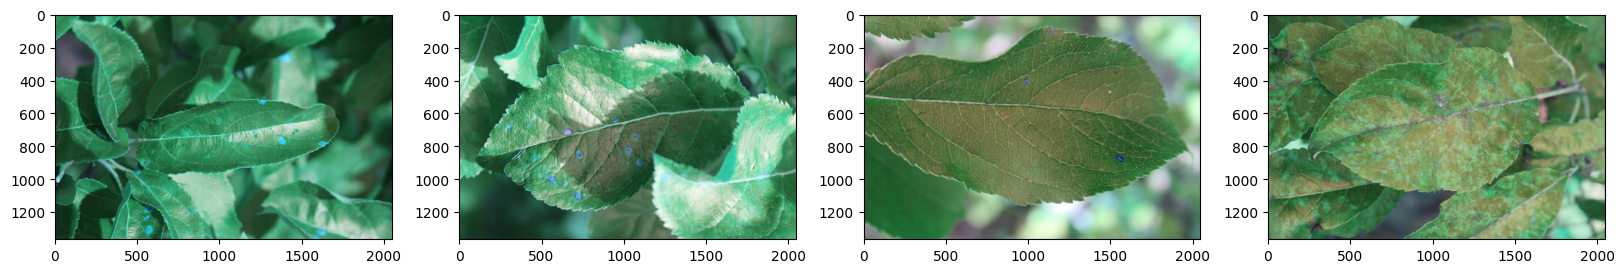

In [5]:
plt.figure(figsize = (20, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    img = cv2.imread(str(listImages[i]))
    plt.imshow(img)
plt.show()

##### Separa em variávies as informações específicas da imagem do conjunto de dados: como identificadores e rótulos

In [6]:
images_id_csv = datasetObject['image_id']
healthy_csv = datasetObject['healthy']
multiple_diseases_csv = datasetObject['multiple_diseases']
rust_csv = datasetObject['rust']
scab_csv = datasetObject['scab']

##### Adiciona uma lista contendo os rótulos correspondente á imagem autal na lista: labels
##### Adiciona uma outra lista com as imagens pré processadas: images

In [7]:
images = []
labels = []
for index, values in enumerate(images_id_csv):
    img = cv2.imread(os.path.join(dataset_folder, "images", "{}.jpg".format(values)))
    img = cv2.resize(img, (100, 100))
    img = img/255
    labels.append([healthy_csv[index], multiple_diseases_csv[index], rust_csv[index],
                 scab_csv[index]])
    images.append(img)

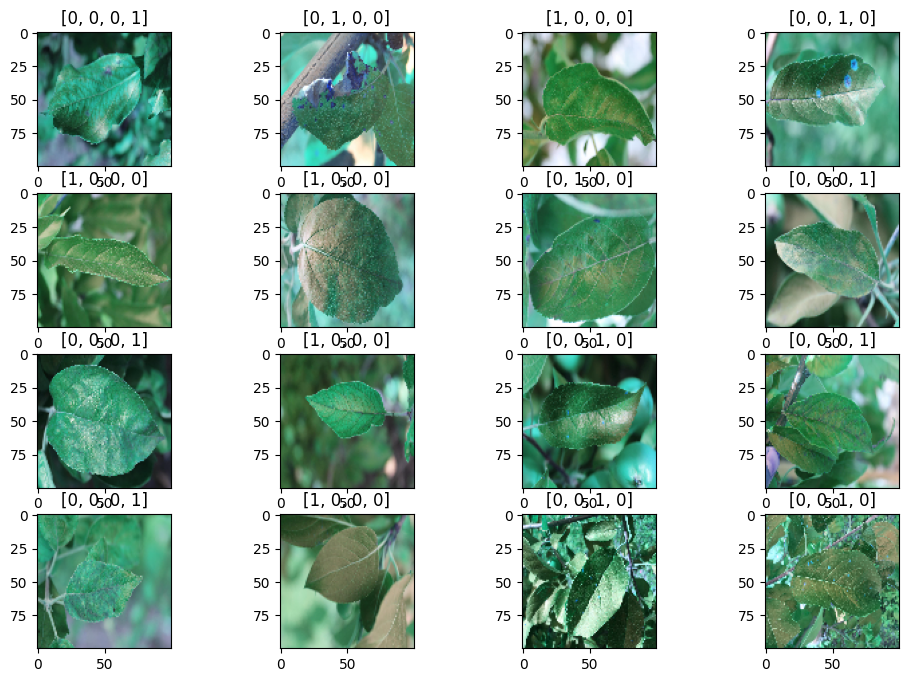

In [8]:
plt.figure(figsize = (12, 8))
for i in range(16):
  plt.subplot(4, 4, i + 1)
  plt.imshow(images[i])
  plt.title(labels[i])
plt.show()

##### ImageDataGenerator é uma classe da biblioteca Keras do TensorFlow que permite gerar automaticamente novas imagens com base em um conjunto de imagens existentes. Será aplicado alguns parâmetros como o ângulo que as imagens podem ser rotacionadas, espelhamento horizontal e vertical...

In [9]:
img_data_g = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=0.35,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        shear_range=0.2,
        width_shift_range=0.15,
        height_shift_range=0.15,
        rescale=None)

##### Data Augentation
##### Aplica o aumento de dados nas imagens originais, gerando nove imagens aumentadas para cada imagem original. As imagens aumentadas e os rótulos correspondentes são armazenados nas listas: images_after_aug e labels_after_aug, respectivamente. Em seguida, as listas são convertidas em arrays NumPy: images e labels para serem usados em algoritmos de aprendizado de máquina.

In [10]:
images_after_aug = []
labels_after_aug = []
for index, image in enumerate(images):
  for i in range(9):
      img = img_data_g.flow(np.reshape(image, (1, 100, 100, 3))).next()
      images_after_aug.append(np.reshape(img, (100, 100, 3)))
      labels_after_aug.append(labels[index])
labels = np.asarray(labels_after_aug)
images = np.asarray(images_after_aug)

##### A forma do array: images será (N, 100, 100, 3), onde N é o número total de imagens após o aumento de dados, e cada imagem tem dimensões de 100x100 pixels com 3 canais de cor (RGB).

In [11]:
images.shape

(16389, 100, 100, 3)

c:\Users\rodri\miniconda3\envs\apple-trees\lib\site-packages\matplotlib\text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


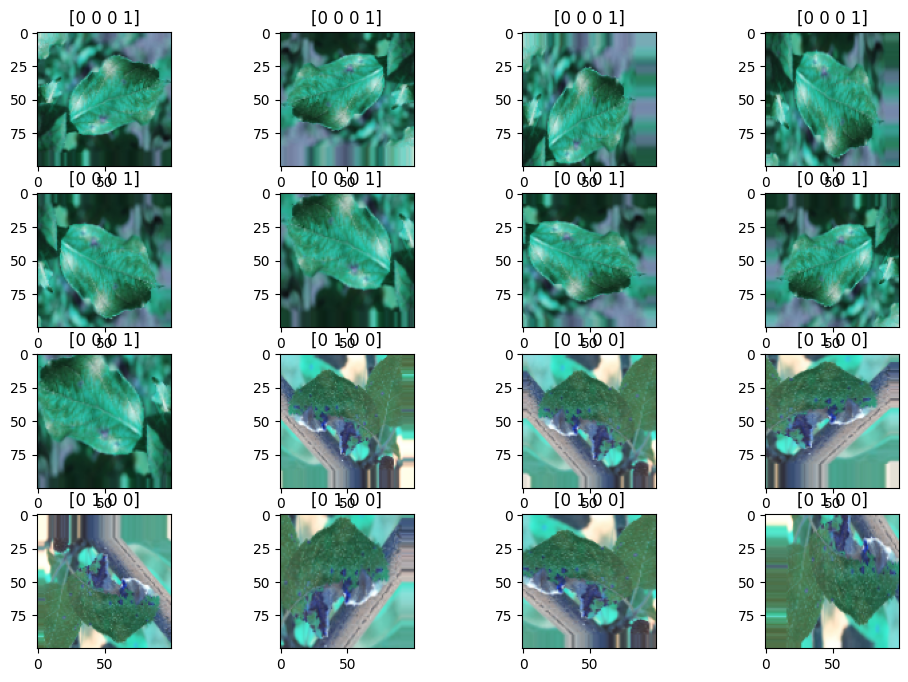

In [12]:
plt.figure(figsize = (12, 8))
for i in range(16):
  plt.subplot(4, 4, i + 1)
  plt.imshow(images[i])
  plt.title(labels[i])
plt.show()

##### Modelo

##### Cria um modelo DenseNet121 com pesos pré-treinados do ImageNet e configura todas as camadas como treináveis para que possam ser ajustadas durante o treinamento com os dados específicos do problema. Importante: include_top=False: Indica que a camada de classificação final (top layer) do DenseNet121 não será incluída no modelo. Isso é útil quando queremos substituir a camada de classificação original por uma nova camada personalizada.

In [13]:
d = tf.keras.applications.DenseNet121(include_top=False,
                   input_shape=(100,100,3),
                   pooling=None,
                   weights='imagenet')
for i in d.layers:
  i.trainable = True

##### Novo modelo é construído adicionando camadas personalizadas ao modelo DenseNet121 existente.

#### Passo a passo:

- Uma camada de pooling global médio é adicionada ao final do modelo DenseNet121 para reduzir a dimensionalidade do tensor de saída para calcular a média de cada canal ao longo de todas as posições espaciais da saída.
- Uma camada de pooling global máximo é adicionada ao final do modelo DenseNet121 para calcular o valor máximo de cada canal ao longo de todas as posições espaciais da saída.
- Mais uma camada que calcula o valor mínimo elemento a elemento entre os tensores de saída do pooling médio global e do pooling máximo global. Isso ajuda a capturar informações diferentes e complementares dos dois tipos de pooling.
- Uma camada de dropout é adicionada para ajudar a reduzir o overfitting, desligando aleatoriamente 50% dos neurônios de entrada durante o treinamento.
- Uma camada densa com 128 neurônios é adicionada, seguida pela função de ativação sigmoid.
- Mais um dropout é adicionado com uma taxa de 30%.
- A camada de saída final é uma camada densa com 4 neurônios (correspondendo aos 4 rótulos possíveis) usando a função de ativação softmax para obter probabilidades de classe.
- O modelo é compilado com o otimizador Adam, função de perda de entropia cruzada e as métricas de avaliação usadas são de precisão e recall.

In [14]:
output_avg = tf.keras.layers.GlobalAveragePooling2D()(d.output)
output_max = tf.keras.layers.GlobalMaxPooling2D()(d.output)
m = tf.keras.layers.minimum([output_avg, output_max])
m = tf.keras.layers.Dropout(0.5)(m)
m = tf.keras.layers.Dense(128, activation = "sigmoid")(m)
m = tf.keras.layers.Dropout(0.3)(m)
m = tf.keras.layers.Dense(256, activation = "relu")(m)
m = tf.keras.layers.Dropout(0.3)(m)
m = tf.keras.layers.Dense(512, activation = "relu")(m)
m = tf.keras.layers.Dropout(0.3)(m)
m = tf.keras.layers.Dense(4, activation= "softmax")(m)
m = tf.keras.models.Model(inputs = d.input, outputs = m)
m.compile(optimizer = tf.keras.optimizers.Adam(0.001), 
          loss = "categorical_crossentropy", 
          metrics =["accuracy", 
                     Precision(name='precision'), 
                     Recall(name='recall')])
m.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 106, 106, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 50, 50, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 50, 50, 64)   256         ['conv1/conv[0][0]']         

##### Variáveis de treino e teste

In [15]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.15, random_state = 42)

In [16]:
x_train.shape

(13930, 100, 100, 3)

In [17]:
x_test.shape

(2459, 100, 100, 3)

##### Treinar o modelo
##### É aqui que a cpu chora e a ventoinha começa a cantar...
##### Importante:
- Uma lista de objetos de callback são usados durante o treinamento para realizar ações específicas, como ajustar a taxa de aprendizado (ReduceLROnPlateau) e parar o treinamento antecipadamente se a perda não estiver melhorando (EarlyStopping).

##### I

In [18]:
history = m.fit(x_train, y_train, epochs=30, batch_size=32,
                callbacks = [
                    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, mode='min', patience=1),
                    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, mode='min', restore_best_weights=True)
                ])

Epoch 1/30
436/436 [==============================] - 654s 1s/step - loss: 0.6640 - accuracy: 0.7608 - precision: 0.8381 - recall: 0.6854 - lr: 0.0010
Epoch 2/30
436/436 [==============================] - 639s 1s/step - loss: 0.3584 - accuracy: 0.8898 - precision: 0.9119 - recall: 0.8673 - lr: 0.0010
Epoch 3/30
436/436 [==============================] - 642s 1s/step - loss: 0.2781 - accuracy: 0.9105 - precision: 0.9315 - recall: 0.8925 - lr: 0.0010
Epoch 4/30
436/436 [==============================] - 641s 1s/step - loss: 0.2368 - accuracy: 0.9247 - precision: 0.9391 - recall: 0.9111 - lr: 0.0010
Epoch 5/30
436/436 [==============================] - 636s 1s/step - loss: 0.2018 - accuracy: 0.9351 - precision: 0.9466 - recall: 0.9253 - lr: 0.0010
Epoch 6/30
436/436 [==============================] - 623s 1s/step - loss: 0.1778 - accuracy: 0.9427 - precision: 0.9525 - recall: 0.9332 - lr: 0.0010
Epoch 7/30
436/436 [==============================] - 638s 1s/step - loss: 0.1656 - accuracy: 

##### Avaliação do modelo de treinamento

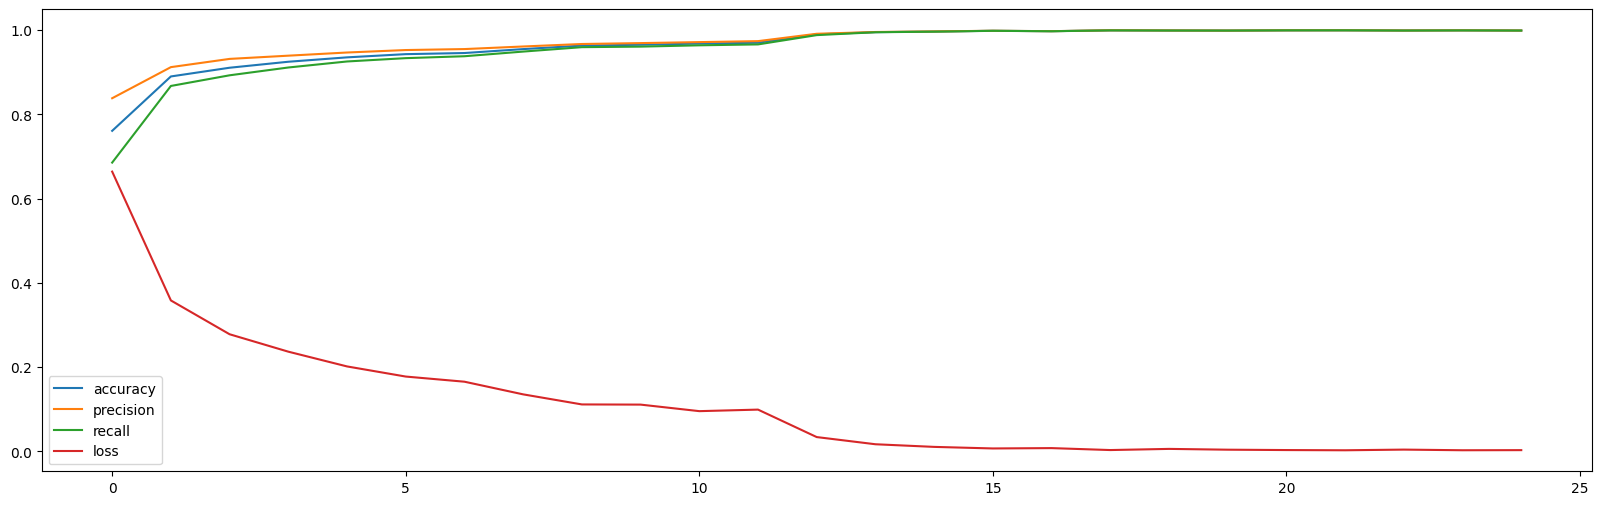

In [19]:
plt.figure(figsize = (20, 6))
plt.plot(history.history['accuracy'], label = "accuracy")
plt.plot(history.history['precision'], label = "precision")
plt.plot(history.history['recall'], label = "recall")
plt.plot(history.history['loss'], label = "loss")
plt.legend()

##### O método evaluate() é usado para avaliar o desempenho de um modelo de rede neural em um conjunto de dados de teste. No código abaixo, será aplicado ao modelo: m usando o conjunto de teste (x_test, y_test) com um tamanho de lote de 32.

In [20]:
m.evaluate(x_test, y_test, batch_size= 32)

77/77 [==============================] - 23s 272ms/step - loss: 0.0951 - accuracy: 0.9813 - precision: 0.9825 - recall: 0.9813


[0.09509623050689697,
 0.9812932014465332,
 0.9824918508529663,
 0.9812932014465332]

##### A função predict() Retorna um array com as previsões para cada entrada no conjunto de teste.

##### Já a função argmax() É usado para encontrar o índice do valor máximo ao longo do eixo 1 do array y_pred. Isso é feito para obter a classe prevista para cada entrada no conjunto de teste.

In [21]:
y_pred = m.predict(x_test)
y_pred = np.argmax(y_pred, axis = 1)

77/77 [==============================] - 22s 270ms/step


In [22]:
y_test = np.argmax(y_test, axis = 1)

##### A função accuracy_score() é parte do módulo sklearn.metrics do scikit-learn e é comumente usada para calcular a acurácia de um modelo de classificação. Ela compara as previsões do modelo com os rótulos verdadeiros e retorna a fração de exemplos que foram previstos corretamente.

In [26]:
cnn_standard_acc = accuracy_score(y_pred, y_test)
print(cnn_standard_acc)

0.9812932086213908


##### A função classification_report() é usada para gerar um relatório de métricas de classificação, como precisão, recall, F1-score, com base nas previsões do modelo (y_pred) e nos rótulos verdadeiros (y_test).

##### O relatório de classificação normalmente inclui as seguintes métricas para cada classe:
- Precision (Precisão): a proporção de exemplos classificados corretamente como positivos em relação ao número total de exemplos classificados como positivos (TP / (TP + FP)).

- Recall (Revocação): a proporção de exemplos classificados corretamente como positivos em relação ao número total de exemplos verdadeiramente positivos (TP / (TP + FN)).

- F1-score: uma métrica que combina a precisão e a revocação em uma única medida que equilibra a importância de ambas.

In [27]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       735
           1       0.80      0.93      0.86        94
           2       0.99      1.00      0.99       826
           3       0.99      0.97      0.98       804

    accuracy                           0.98      2459
   macro avg       0.94      0.97      0.95      2459
weighted avg       0.98      0.98      0.98      2459



##### A matriz de confusão é uma ferramenta útil para avaliar o desempenho de um modelo de classificação. 
##### Ela mostra a contagem de exemplos que foram classificados corretamente e incorretamente para cada classe. As linhas da matriz representam as classes reais, enquanto as colunas representam as classes previstas pelo modelo.

In [ ]:
def generate_confusion_matrix(y_pred, y_test):
    c = tf.math.confusion_matrix(y_pred, y_test)
    sns.heatmap(c, annot=True)

In [ ]:
generate_confusion_matrix(y_pred, y_test)